In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
from collections import namedtuple
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# Hidden Markov Model Analysis

The most basic way that this problem can be modeled is using graphical hidden markov models.

Let *f* denote females, *m* denote males and *u* denote nodes with an unknown sex. <br>
In addition, let d(.) be a function that returns the latent state size of the input
<br><br>
For every root in the pedigree
$$
f_x \sim \pi_{f_0} \\
m_x \sim \pi_{m_0}
$$
For every child *c* in the pedigree with mother *f* and father *m*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(f), j=1...d(m), k=1...d(c)
$$
c_{x_k} \sim \pi_{ijk}f_{x_i}m_{x_j} \\
$$
For each node *n*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(n)
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is female:
$$
n_{y_j} \sim L_{f_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is male:
$$
n_{y_j} \sim L_{m_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is unknown:
$$
n_{y_j} \sim L_{u_ij}n_{x_i}
$$

Each of the parameters will have a different Dirichlet prior over their last axis.  The root distributions will have a weak prior as there is no way of knowing what their distribution can be and the transition and emission distributions will have priors determined by [Mendelian Inheritance](https://en.wikipedia.org/wiki/Mendelian_inheritance) depending on the model.  The prior (with strength included) will be called *G* and *H* respectively.  There will be an *H* for each different sex
$$
\pi_{\{.\}_0} \sim \text{Dirichlet}( 1 ) \\
\pi_{ij} \sim \text{Dirichlet}(G) \\
L_{\{.\}_i} \sim \text{Dirichlet}(H_{\{.\}})
$$

# Load the dataset.  The feedback sets will be automatically determined

In [82]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import PedigreeHMMFilter, PedigreeHMMFilterSexMatters
from GenModels.research.Models import *

In [3]:
graphs = load()

Graph 1038CG.json is incorrect. This graph is disjoint!!!
Graph 1044IO.json is incorrect. This graph is disjoint!!!
Graph 1083BF.json is incorrect. This graph is disjoint!!!
Graph 2018LM.json is incorrect. This graph is disjoint!!!
Graph 2049EE.json is incorrect. This graph is disjoint!!!
Graph 3011JB.json is incorrect. Edge before: 1 but tried setting: 2
Graph 3267NF.json is incorrect. This graph is disjoint!!!
Graph 329JR.json is incorrect. This graph is disjoint!!!
Graph 3379KS.json is incorrect. Edge before: 6 but tried setting: 8
Graph 3420MZ.json is incorrect. Can't have an edge with no children!!!!
Graph 3427NF.json is incorrect. This graph is disjoint!!!
Graph 346GT.json is incorrect. This graph is disjoint!!!
Graph 3605JG.json is incorrect. This graph is disjoint!!!
Graph 3672DW.json is incorrect. This graph is disjoint!!!
Graph 370JF.json is incorrect. This graph is disjoint!!!
Graph 371KD.json is incorrect. This graph is disjoint!!!
Graph 3743MH.json is incorrect. This graph

In [4]:
len( graphs )

476

# Verify that things look as expected

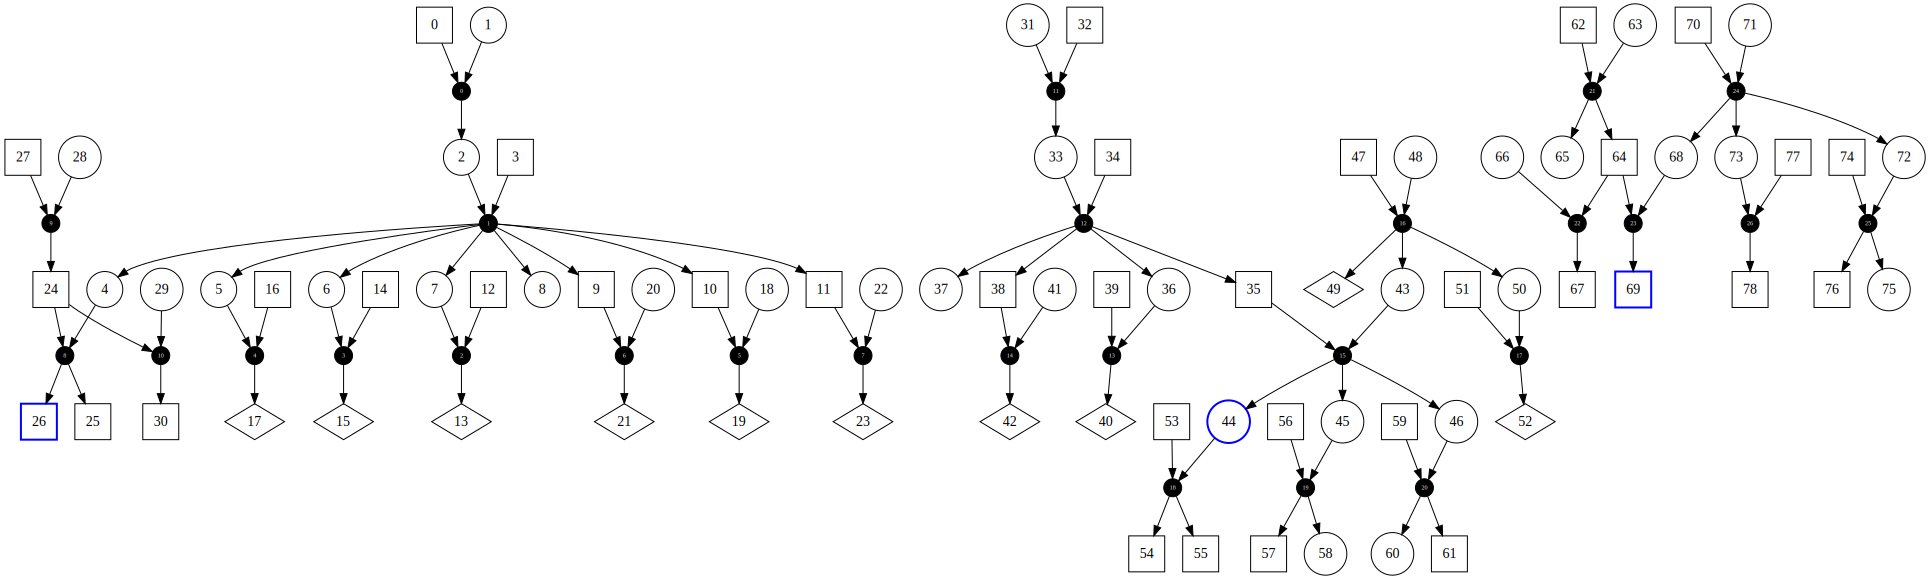

In [5]:
temp = PedigreeHMMFilter()
temp.preprocessData( graphs[ :3 ] )
temp.draw()

# Separate the labeled pedigrees

In [6]:
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]
print( 'Number of graphs for - AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for - AD: 151 AR: 215 XL: 107


# Autosomal Models

### Dominant

In [67]:
msg_autosomal_dominant = PedigreeHMMFilter()
msg_autosomal_dominant.preprocessData( ad_graphs[ :1 ] )

# Priors
autosomal_trans_prior = autosomalTransitionPrior()
autosomal_dominant_emiss_prior = autosomalDominantEmissionPrior()

# Gibbs Model
ad_gibbs_params = AutosomalParametersGibbs( transition_prior=autosomal_trans_prior, emission_prior=autosomal_dominant_emiss_prior )
ad_gibbs_model = Gibbs( msg=msg_autosomal_dominant, parameters=ad_gibbs_params )

# EM Model
ad_em_params = AutosomalParametersEM( transition_prior=autosomal_trans_prior, emission_prior=autosomal_dominant_emiss_prior )
ad_em_model = EM( msg=msg_autosomal_dominant, parameters=ad_em_params )

# CAVI Model
ad_cavi_params = AutosomalParametersCAVI( transition_prior=autosomal_trans_prior, emission_prior=autosomal_dominant_emiss_prior )
ad_cavi_model = CAVI( msg=msg_autosomal_dominant, parameters=ad_cavi_params )

### Recessive

In [68]:
msg_autosomal_recessive = PedigreeHMMFilter()
msg_autosomal_recessive.preprocessData( ar_graphs[ :1 ] )

# Priors
autosomal_trans_prior = autosomalTransitionPrior()
autosomal_recessive_emiss_prior = autosomalRecessiveEmissionPrior()

# Gibbs Model
ar_gibbs_params = AutosomalParametersGibbs( transition_prior=autosomal_trans_prior, emission_prior=autosomal_recessive_emiss_prior )
ar_gibbs_model = Gibbs( msg=msg_autosomal_recessive, parameters=ar_gibbs_params )

# EM Model
ar_em_params = AutosomalParametersEM( transition_prior=autosomal_trans_prior, emission_prior=autosomal_recessive_emiss_prior )
ar_em_model = EM( msg=msg_autosomal_recessive, parameters=ar_em_params )

# CAVI Model
ar_cavi_params = AutosomalParametersCAVI( transition_prior=autosomal_trans_prior, emission_prior=autosomal_recessive_emiss_prior )
ar_cavi_model = CAVI( msg=msg_autosomal_recessive, parameters=ar_cavi_params )

# X-Linked Models

In [83]:
msg_xlinked = PedigreeHMMFilterSexMatters()
msg_xlinked.preprocessData( xl_graphs[ :1 ] )

# Priors for each sex
xlinked_female_trans_prior = xLinkedFemaleTransitionPrior()
xlinked_male_trans_prior = xLinkedMaleTransitionPrior()
xlinked_unknown_trans_prior = xLinkedUnknownTransitionPrior()
xlinked_trans_priors = [ xlinked_female_trans_prior, xlinked_male_trans_prior, xlinked_unknown_trans_prior ]

xlinked_female_emiss_prior = xLinkedFemaleEmissionPrior()
xlinked_male_emiss_prior = xLinkedMaleEmissionPrior()
xlinked_unknown_emiss_prior = xLinkedUnknownEmissionPrior()
xlinked_emiss_priors = [ xlinked_female_emiss_prior, xlinked_male_emiss_prior, xlinked_unknown_emiss_prior ]

# Gibbs Model
xl_gibbs_params = XLinkedParametersGibbs( transition_priors=xlinked_trans_priors, emission_priors=xlinked_emiss_priors )
xl_gibbs_model = Gibbs( msg=msg_xlinked, parameters=xl_gibbs_params )

# EM Model
xl_em_params = XLinkedParametersEM( transition_priors=xlinked_trans_priors, emission_priors=xlinked_emiss_priors )
xl_em_model = GroupEM( msg=msg_xlinked, parameters=xl_em_params )

# CAVI Model
xl_cavi_params = XLinkedParametersCAVI( transition_priors=xlinked_trans_priors, emission_priors=xlinked_emiss_priors )
xl_cavi_model = GroupCAVI( msg=msg_xlinked, parameters=xl_cavi_params )

# Gibbs

In [ ]:
start = time.time()
for _ in range( 10 ):
    ad_gibbs_model.fitStep()
print( 'Took', time.time() - start, 'seconds' )

# EM

In [ ]:
start = time.time()
last_marginal = 0
for _ in range( 10 ):
    marginal = ad_em_model.fitStep()
    print( marginal, marginal - last_marginal )
    last_marginal = marginal
print( 'Took', time.time() - start, 'seconds' )

# CAVI

In [ ]:
start = time.time()
last_elbo = 0
for _ in range( 10 ):
    elbo = ad_cavi_model.fitStep()
    print( elbo, elbo - last_elbo )
    last_elbo = elbo
print( 'Took', time.time() - start, 'seconds' )

In [ ]:
msg = PedigreeHMMFilterSexMatters()
msg.preprocessData( graphs[ :1 ] )